In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import umap

import pandas as pd
from scipy.spatial import cKDTree

from matplotlib import cm
cmap = cm.tab10

In [3]:
basePaths = ["../../",
             "../../test-halfdata/",
             "../../test-halfresnetdepth/",
             "../../test-halfresnetrepdim/",
             "../../test-halfresneprojdim/"]
df = pd.read_csv('../../dataset/m_test.csv')
                           
print(df.columns.values)

['z' 'stellar_mass' 'gas_mass' 'm200c' 'm500c' 'bh_mass' 'bh_accr'
 'halo_num' 'snapshot_id' 'subhalo_id' 'projection' 'image_path']


In [4]:
import pandas as pd
from sklearn.utils import shuffle

#Set seed
SEED = 0

#Plot a single UMAP of x with color c
def create_umap(x, n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        densmap=False,
        random_state=SEED
    )
    u = fit.fit_transform(x);
    
    return np.array(u)
        

n_neighbors = [10, 50, 100]
min_dist = [0.1, 0.5, 1]

for n in n_neighbors:
    for dist in min_dist:
        try:
            u = create_umap(rep, n_neighbors=n, min_dist=dist)
            d = {'u_0': u[:,0], 'u_1': u[:,1], 'dataset': df['dataset']}
            plt.title('n_neighbors = ' + str(n) + ' ' + 'min_dist = ' + str(dist))
            sns.kdeplot(data=pd.DataFrame(d), x='u_0', y='u_1', hue="dataset")
            plt.show()
        except:
            print('n_neighbors = ' + str(n) + ' ' + 'min_dist = ' + str(dist) + ' failed!')

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


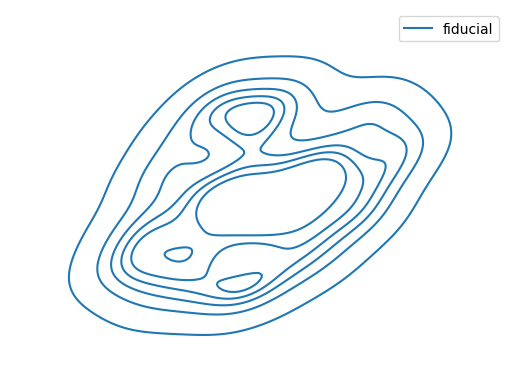

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


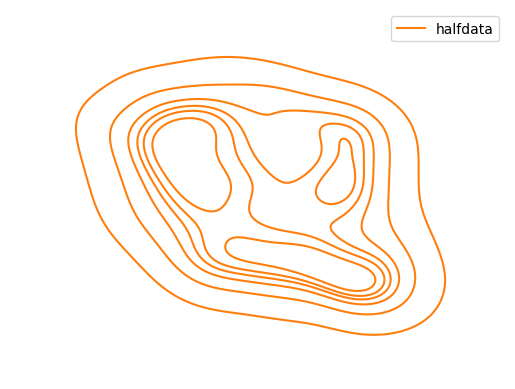

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


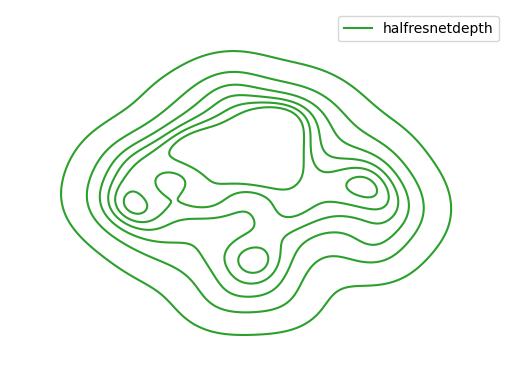

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


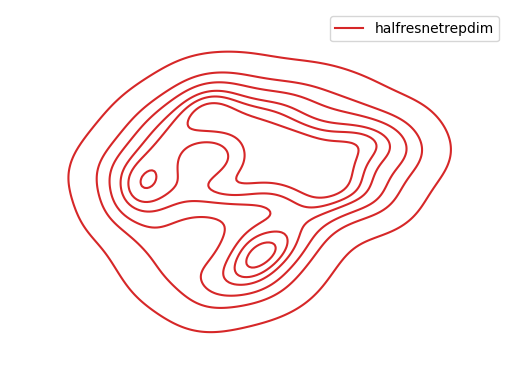

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


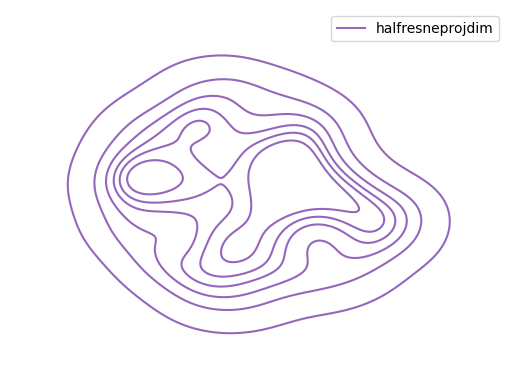

In [5]:
def get_umap(basePath):
    with open(basePath+'postprocessing/representation.npy', 'rb') as f:
        rep = np.load(f)
    u = create_umap(rep, n_neighbors=100, min_dist=0.5)
    return u

def plot_kde(u, df, palette = {'fiducial': fiducial_color}, key='fiducial'):
    d = {'u_0': u[:,0], 'u_1': u[:,1], 'Dataset': np.array([key]*len(df))}
    d = pd.DataFrame(d)
    # print(d)
    
    #TNG vs all HSC
    g = sns.kdeplot(data=d, x='u_0', y='u_1', hue="Dataset", palette=palette, common_norm=False, levels = 7)
    g.get_legend().set_title(None)
    ax = plt.gca()
    ax.axis('off')
    g.get_figure().savefig("../../temp/kde.pdf") 
    plt.show()

from matplotlib import cm
cmap = cm.tab10

for basePath in basePaths:
    try:
        name = basePath.split('test-')[1].split('/')[0]
    except IndexError:
        name = 'fiducial'
    u = get_umap(basePath)
    df = pd.read_csv(basePath+"/dataset/m_test.csv")
    plot_kde(u, df, palette={name:cmap(basePaths.index(basePath))}, key=name)

In [6]:
reference = pd.read_csv('../../dataset_raw/Xray-TNG-Cluster/label.csv')
reference.keys()

Index(['z', 'stellar_mass', 'gas_mass', 'm200c', 'm500c', 'bh_mass', 'bh_accr',
       'halo_num', 'snapshot_id', 'subhalo_id', 'projection', 'image_path',
       'num_mergers_r>03', 'num_mergers_r>01', 'log_sfr', 'bh_tinj_cum',
       'bh_kinj_cum', 'bh_einj_cum'],
      dtype='object')

In [7]:
def add_data(df, reference=reference):
    allkeys = reference.keys()
    for key in allkeys:
        # print(key)
        if key not in df.keys():
            # print('adding')
            ncol = len(df.keys())
            df.insert(ncol, key, np.zeros(len(df)))
            for i in range(len(df)):
                mask = (reference['snapshot_id'] == df['snapshot_id'][i]) * (reference['subhalo_id'] == df['subhalo_id'][i])
                df[key].values[i] = reference[key].values[mask][0]
            # print(key, 'done')

In [8]:
def log_columns(df):
    for column in df.columns:
        if ('mass' in column) or ('00c' in column) or ('accr' in column) or ('inj' in column):
            val0 = df[column].values
            df[column] = np.log10(val0)

df = pd.read_csv(basePaths[0]+'/dataset/m_test.csv')
add_data(df)
log_columns(df)

# "ah, we have to append the BH-Einj and merger values!"
for column in df.columns:
    if 'path' not in column:
        # if ('mass' in column) or ('00c' in column) or ('accr' in column):
        print(column,'%.1f, %.1f' % (df[column].min(), df[column].max()))

z 0.0, 1.0
stellar_mass 11.5, 13.1
gas_mass 12.5, 14.6
m200c 13.5, 15.3
m500c 13.2, 15.1
bh_mass 6.9, 10.5
bh_accr -0.2, 10.0
halo_num 0.0, 20720119.0
snapshot_id 50.0, 99.0
subhalo_id 0.0, 15105605.0
projection 0.0, 2.0
num_mergers_r>03 0.0, 17.0
num_mergers_r>01 1.0, 32.0
log_sfr -2.3, 3.6
bh_tinj_cum 5.1, 9.6
bh_kinj_cum -0.3, 9.6
bh_einj_cum 5.1, 9.8


../../


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


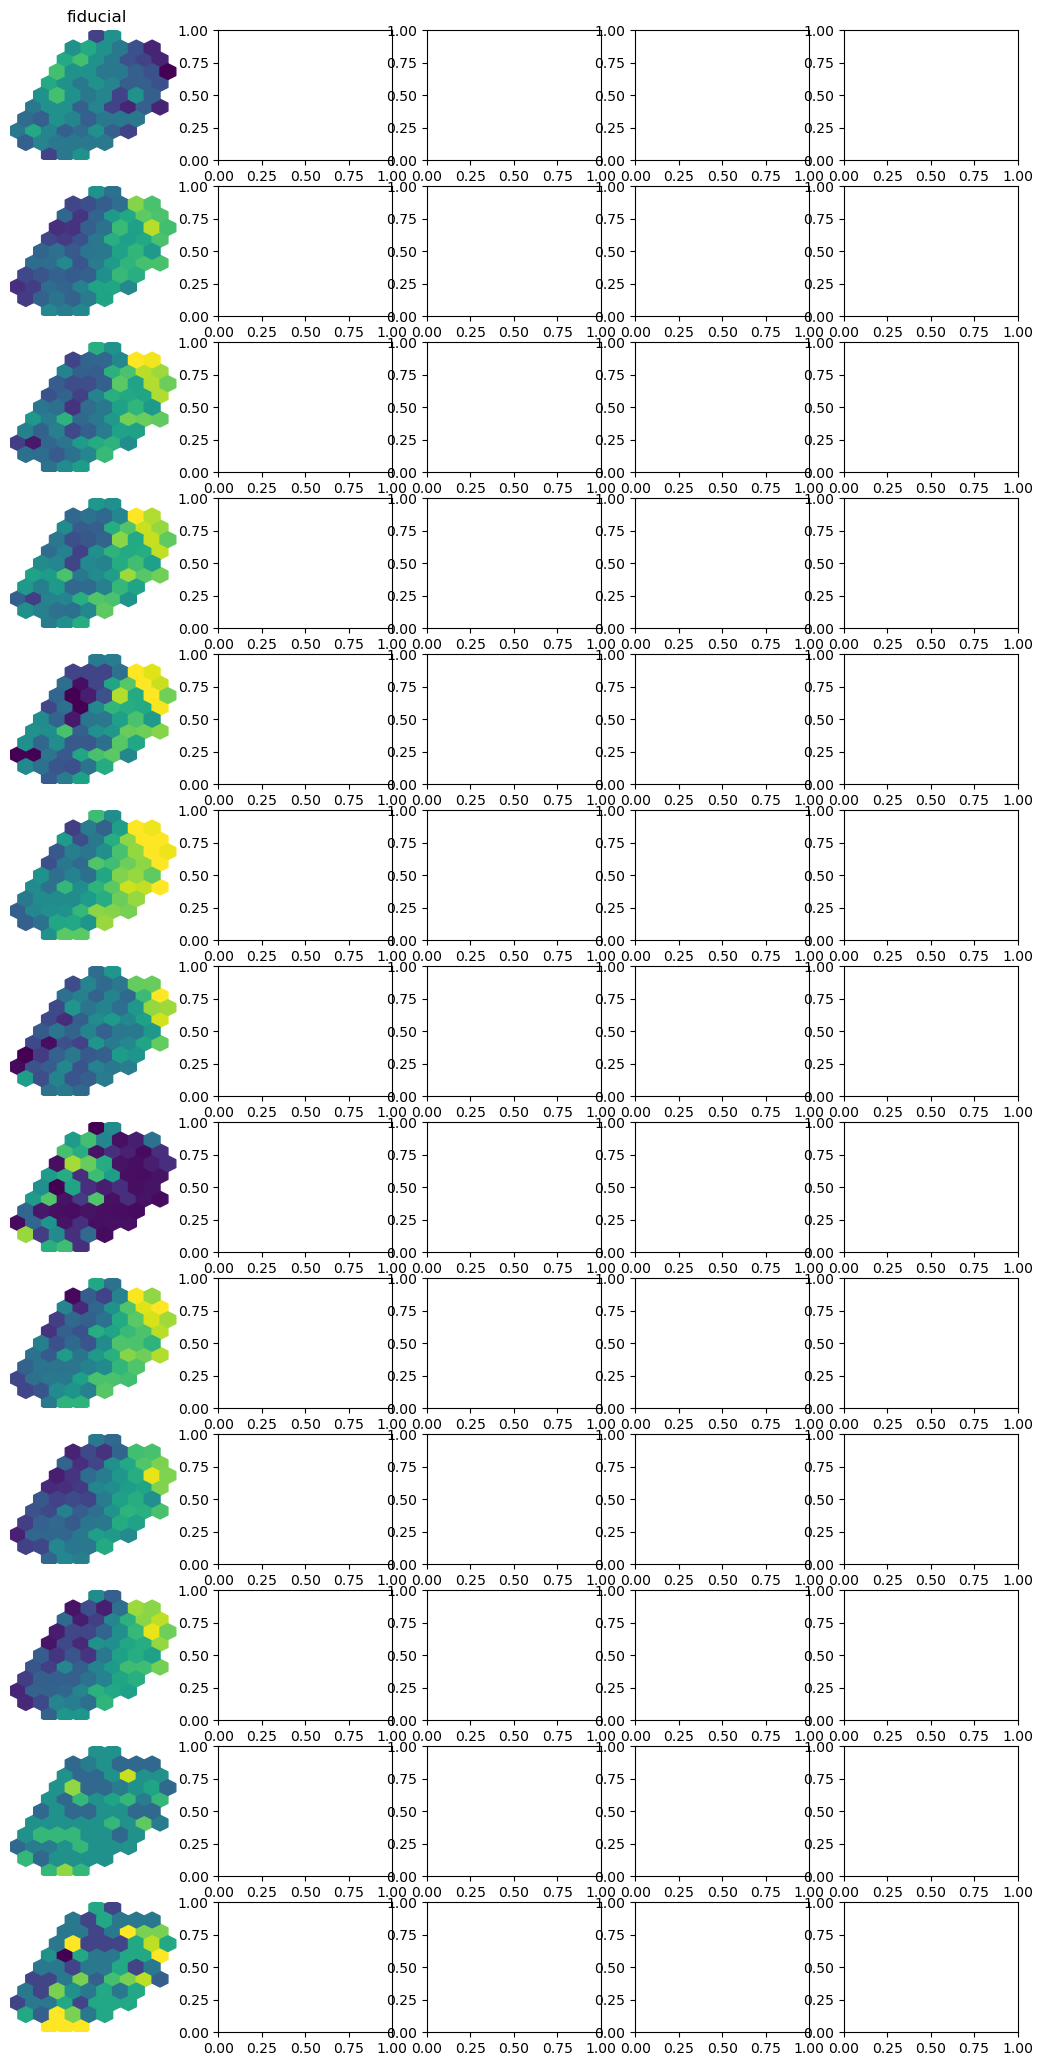

../../test-halfdata/


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


../../test-halfresnetdepth/


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


../../test-halfresnetrepdim/


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


../../test-halfresneprojdim/


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Figure size 640x480 with 0 Axes>

In [59]:

#Prepare the data for the plotting
vmin = {'z':0, 'stellar_mass':12, 'gas_mass':13.2, 'm200c':14, 'm500c':14, 'bh_mass':9, 'bh_accr':5.5, 'log_sfr': -2.3,
        'bh_tinj_cum': 8.2, 'bh_kinj_cum': 8, 'bh_einj_cum':8.5, 'num_mergers_r>03': 0, 'num_mergers_r>01': 5}
vmax = {'z':1, 'stellar_mass':13, 'gas_mass':14.2, 'm200c':15, 'm500c':14.75, 'bh_mass':10, 'bh_accr':8, 'log_sfr': 1, 
        'bh_tinj_cum': 9.2, 'bh_kinj_cum': 9.2, 'bh_einj_cum':9.5, 'num_mergers_r>03': 6, 'num_mergers_r>01': 10}
gridsize = 10
palette = {}
for basePath in basePaths:
    try:
        name = basePath.split('test-')[1].split('/')[0]
    except IndexError:
        name = 'fiducial'
    palette[name] = cmap(basePaths.index(basePath))
    
label_human_dict = {'z': 'Redshift',
                    'stellar_mass': r'Stellar Mass [$M_\odot$]',
                    'gas_mass': r'Gas Mass [$M_\odot$]',
                    'bh_mass': r'SMBH Mass [$M_\odot$]',
                    'm200c': r'M$_{200c}$ [$M_\odot$]', 
                    'm500c': r'M$_{500c}$ [$M_\odot$]', 
                    'bh_accr': r'BHAR [$M_\odot/Gyr$]',
                    'bh_einj_cum': r'$E_{inj, cum} (Tot)$ [erg]',
                    'bh_tinj_cum': r'$E_{inj, cum} (Therm)$ [erg]', 
                    'bh_kinj_cum': r'$E_{inj, cum} (Kin)$ [erg]', 
                    'log_sfr': r'log(SFR) [$M_\odot/yr$]',
                    'num_mergers_r>03': r'# mergers with R > 1:3',
                    'num_mergers_r>01': r'# mergers with R > 1:10'}

label_list = vmin.keys()
def plot_umaps(basePath, axis_column, fig, vmin, vmax, gridsize, label_human_dict, colorbar=False):
    try:
        name = basePath.split('test-')[1].split('/')[0]
    except IndexError:
        name = 'fiducial'

    df = pd.read_csv(basePath+'/dataset/m_test.csv')
    add_data(df)
    log_columns(df)

    print(basePath)
    u = get_umap(basePath)

    i = 0
    for label in label_list:
#         mask = mask_dict[d]
        C = df[label]#[mask]
        
        if sum(C.notna()) == 0:
            continue
        
        im = axis_column[i].hexbin(u[:,0],u[:,1], #u[mask,0],u[mask,1],
                   C=C,
                   gridsize=gridsize,
                   mincnt=5,
                   reduce_C_function=np.median,
                   vmin = vmin[label], 
                   vmax = vmax[label])

    
        #Print kde
        # sns.kdeplot(x=u[:,0], y=u[:,1], levels=[0.2], linewidths=5, linestyles='dashed', color=palette[name], ax=axis_column[i])
        
        if colorbar:
            plt.colorbar(im, label=label_human_dict[label], ax = axis_column[i])
        axis_column[i].axis('off')
        if not i:
            axis_column[i].set_title(name)#, transform=axis_column[i].transAxes)
        fig.savefig('../../temp/umap_compare_models.pdf')
        i += 1
    plt.show()

fig, ax = plt.subplots(nrows = len(label_list), ncols = len(basePaths), figsize=(13,26))
for basePath in basePaths:
    plot_umaps(basePath, ax[:,basePaths.index(basePath)], fig, vmin, vmax, gridsize, label_human_dict, colorbar = (basePath == basePaths[-1]))

In [60]:
plt.tight_layout()
fig.savefig('../../temp/umap_compare_models.pdf')

<Figure size 640x480 with 0 Axes>

In [10]:
def get_u_mesh(u, NUM_IMAGES_PER_SIDE=24):
    u0 = np.linspace(np.min(u[:,0]), np.max(u[:,0]), num=NUM_IMAGES_PER_SIDE)
    u1 = np.linspace(np.min(u[:,1]), np.max(u[:,1]), num=NUM_IMAGES_PER_SIDE)
    
    u0v, u1v = np.meshgrid(u0, u1)
    return u0, u1, u0v, u1v

def get_filenames(basePath, mask=None, NUM_IMAGES_PER_SIDE = 24):
    df = pd.read_csv(basePath+'/dataset/m_test.csv')
    u = get_umap(basePath)
    print(df.shape, u.shape)
    if not mask:
        mask = [True]*len(df)
    tree = cKDTree(u[mask,:], compact_nodes=False, balanced_tree=False)
    image_paths = df['image_path'][mask].to_numpy()

    _, _, u0v, u1v = get_u_mesh(u, NUM_IMAGES_PER_SIDE)
    filenames = np.empty_like(u0v, dtype=object)
    MAX_DISTANCE = 0.2

    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
            distance, index = tree.query([u0v[i,j], u1v[i,j]], k=[1], p=1, workers=-1)

            if distance < MAX_DISTANCE:
                filenames[i,j] = "../../" + image_paths[index][0]
            else:
                filenames[i,j] = ""
                
    return filenames


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(772, 12) (772, 2)


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


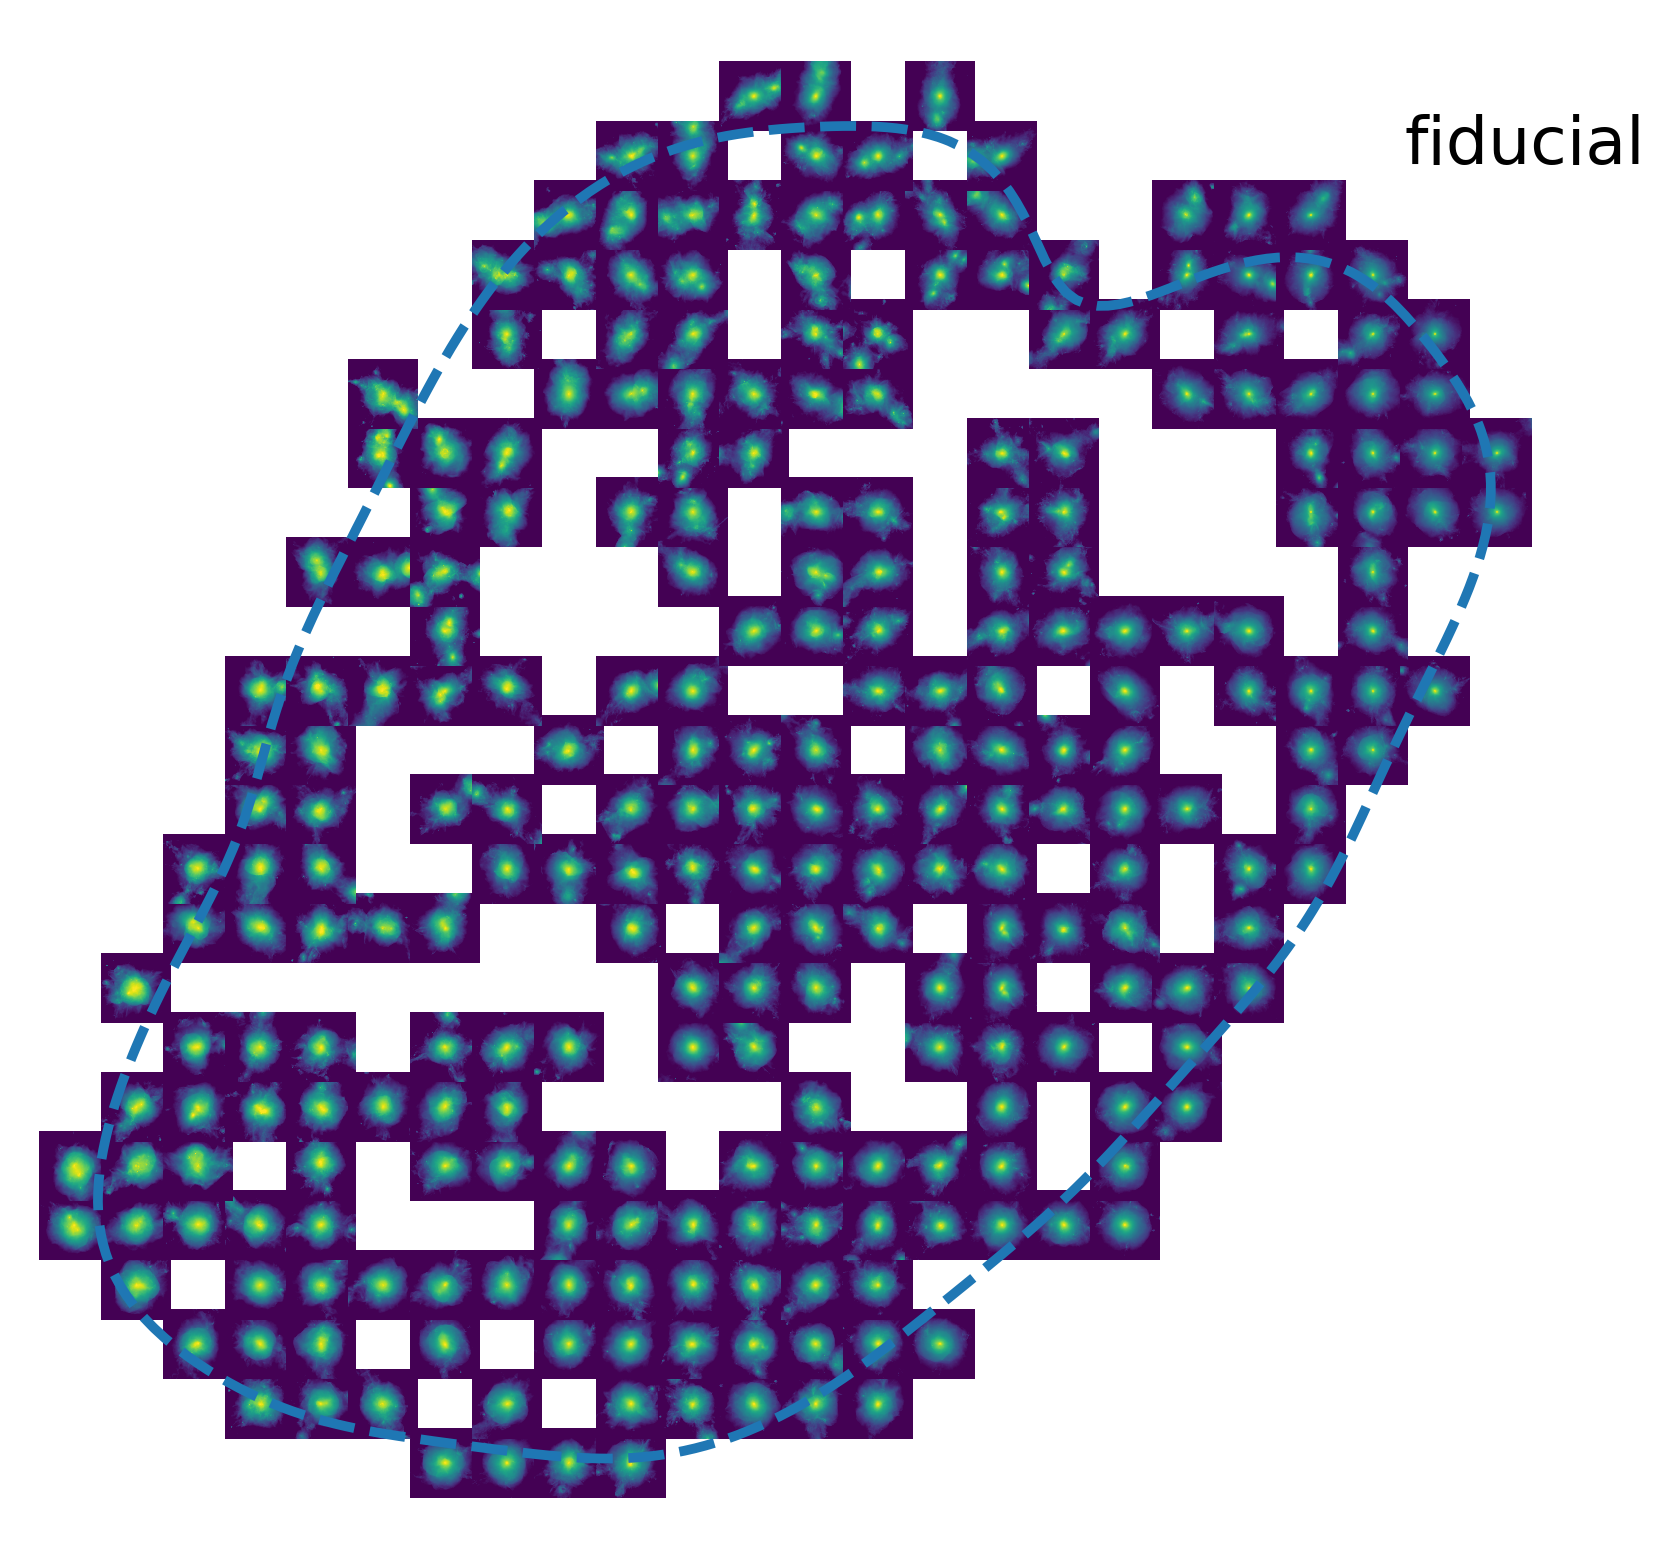

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(406, 13) (406, 2)


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


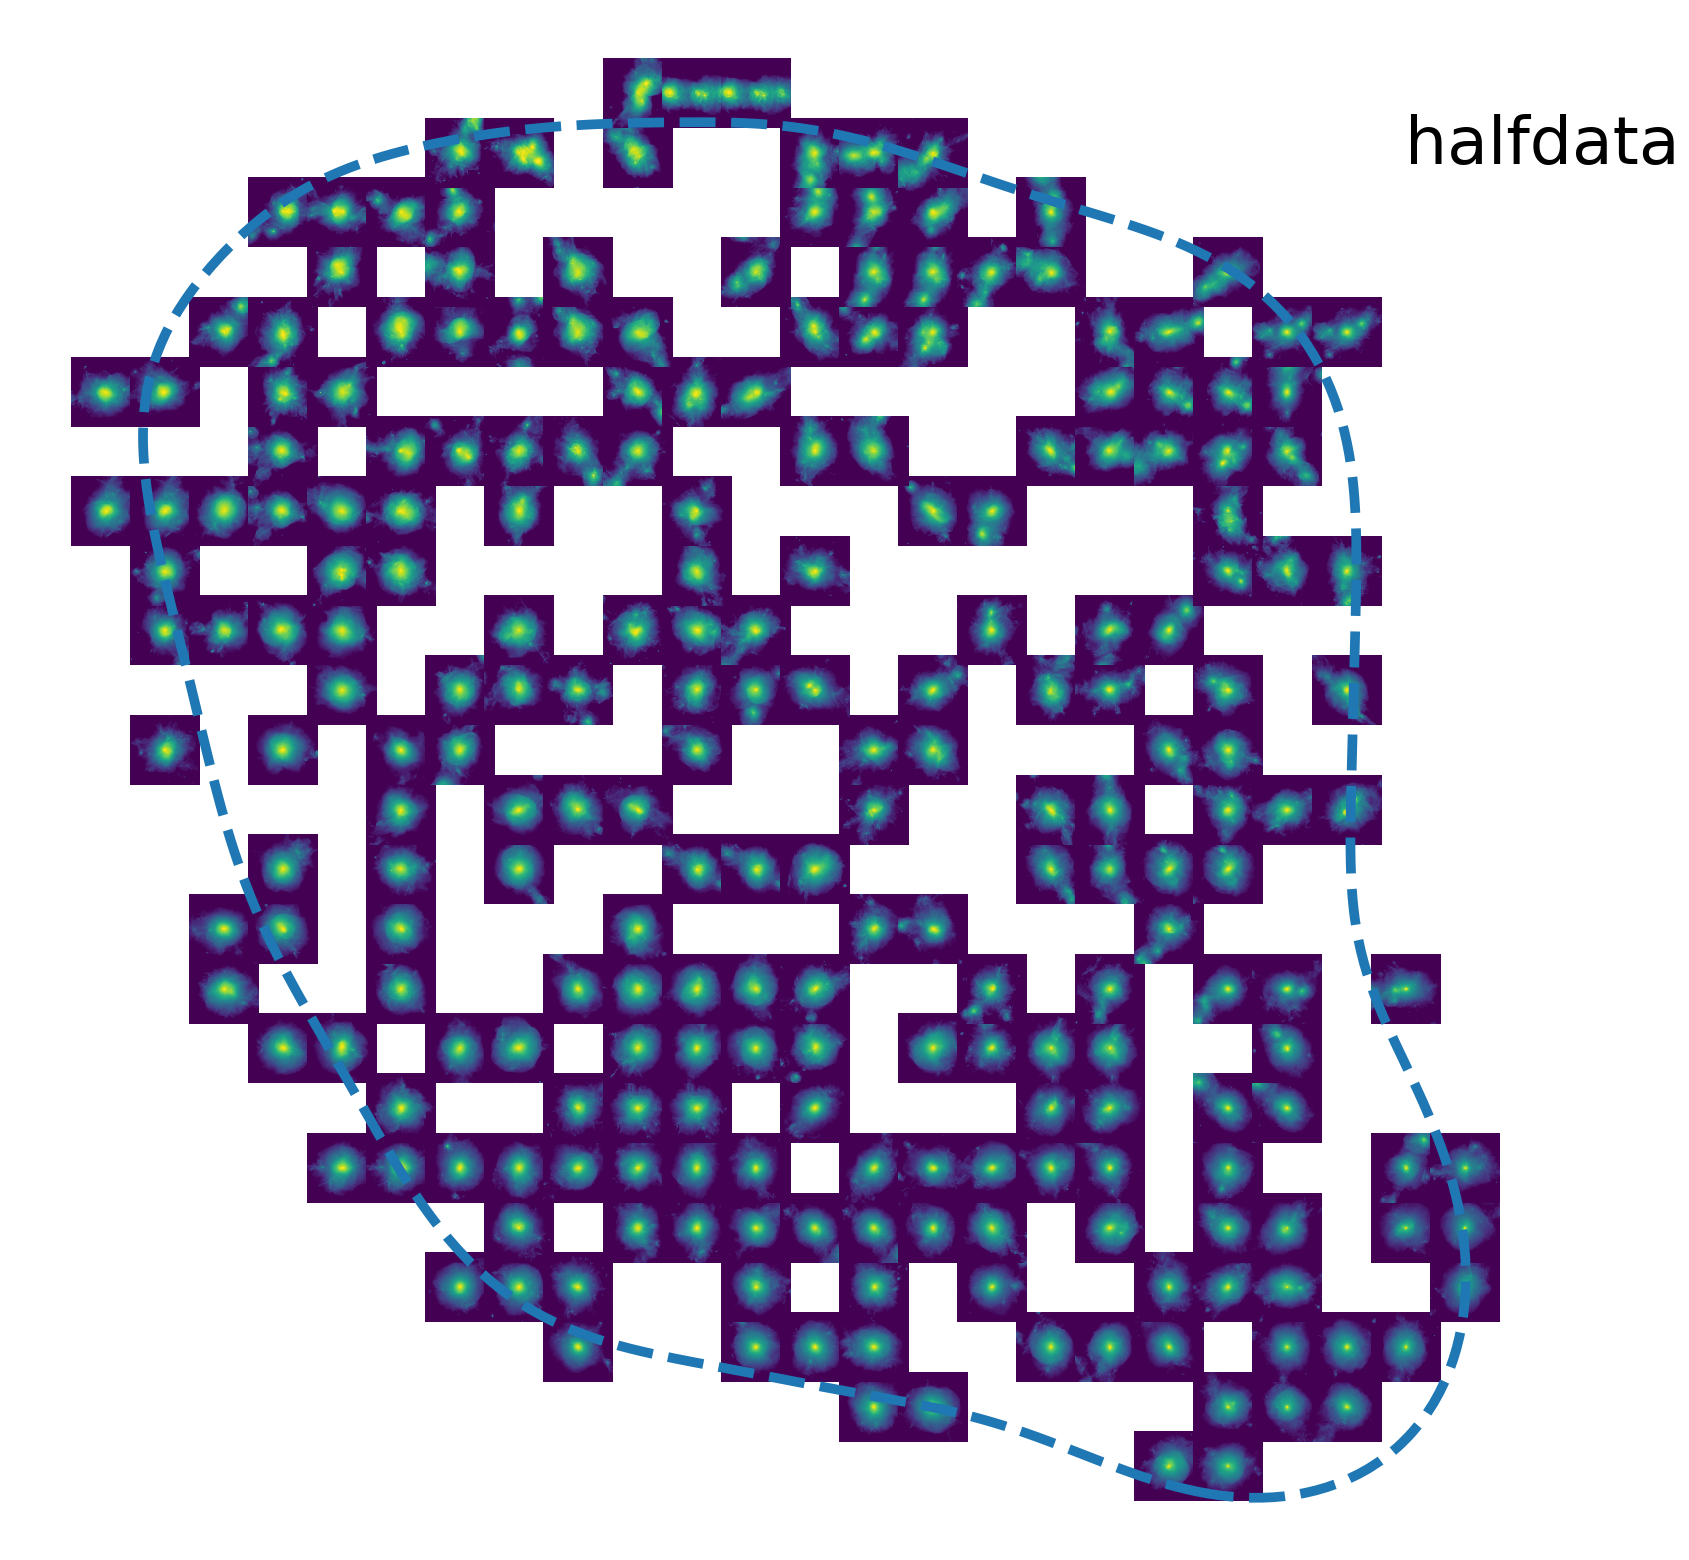

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(772, 16) (772, 2)


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


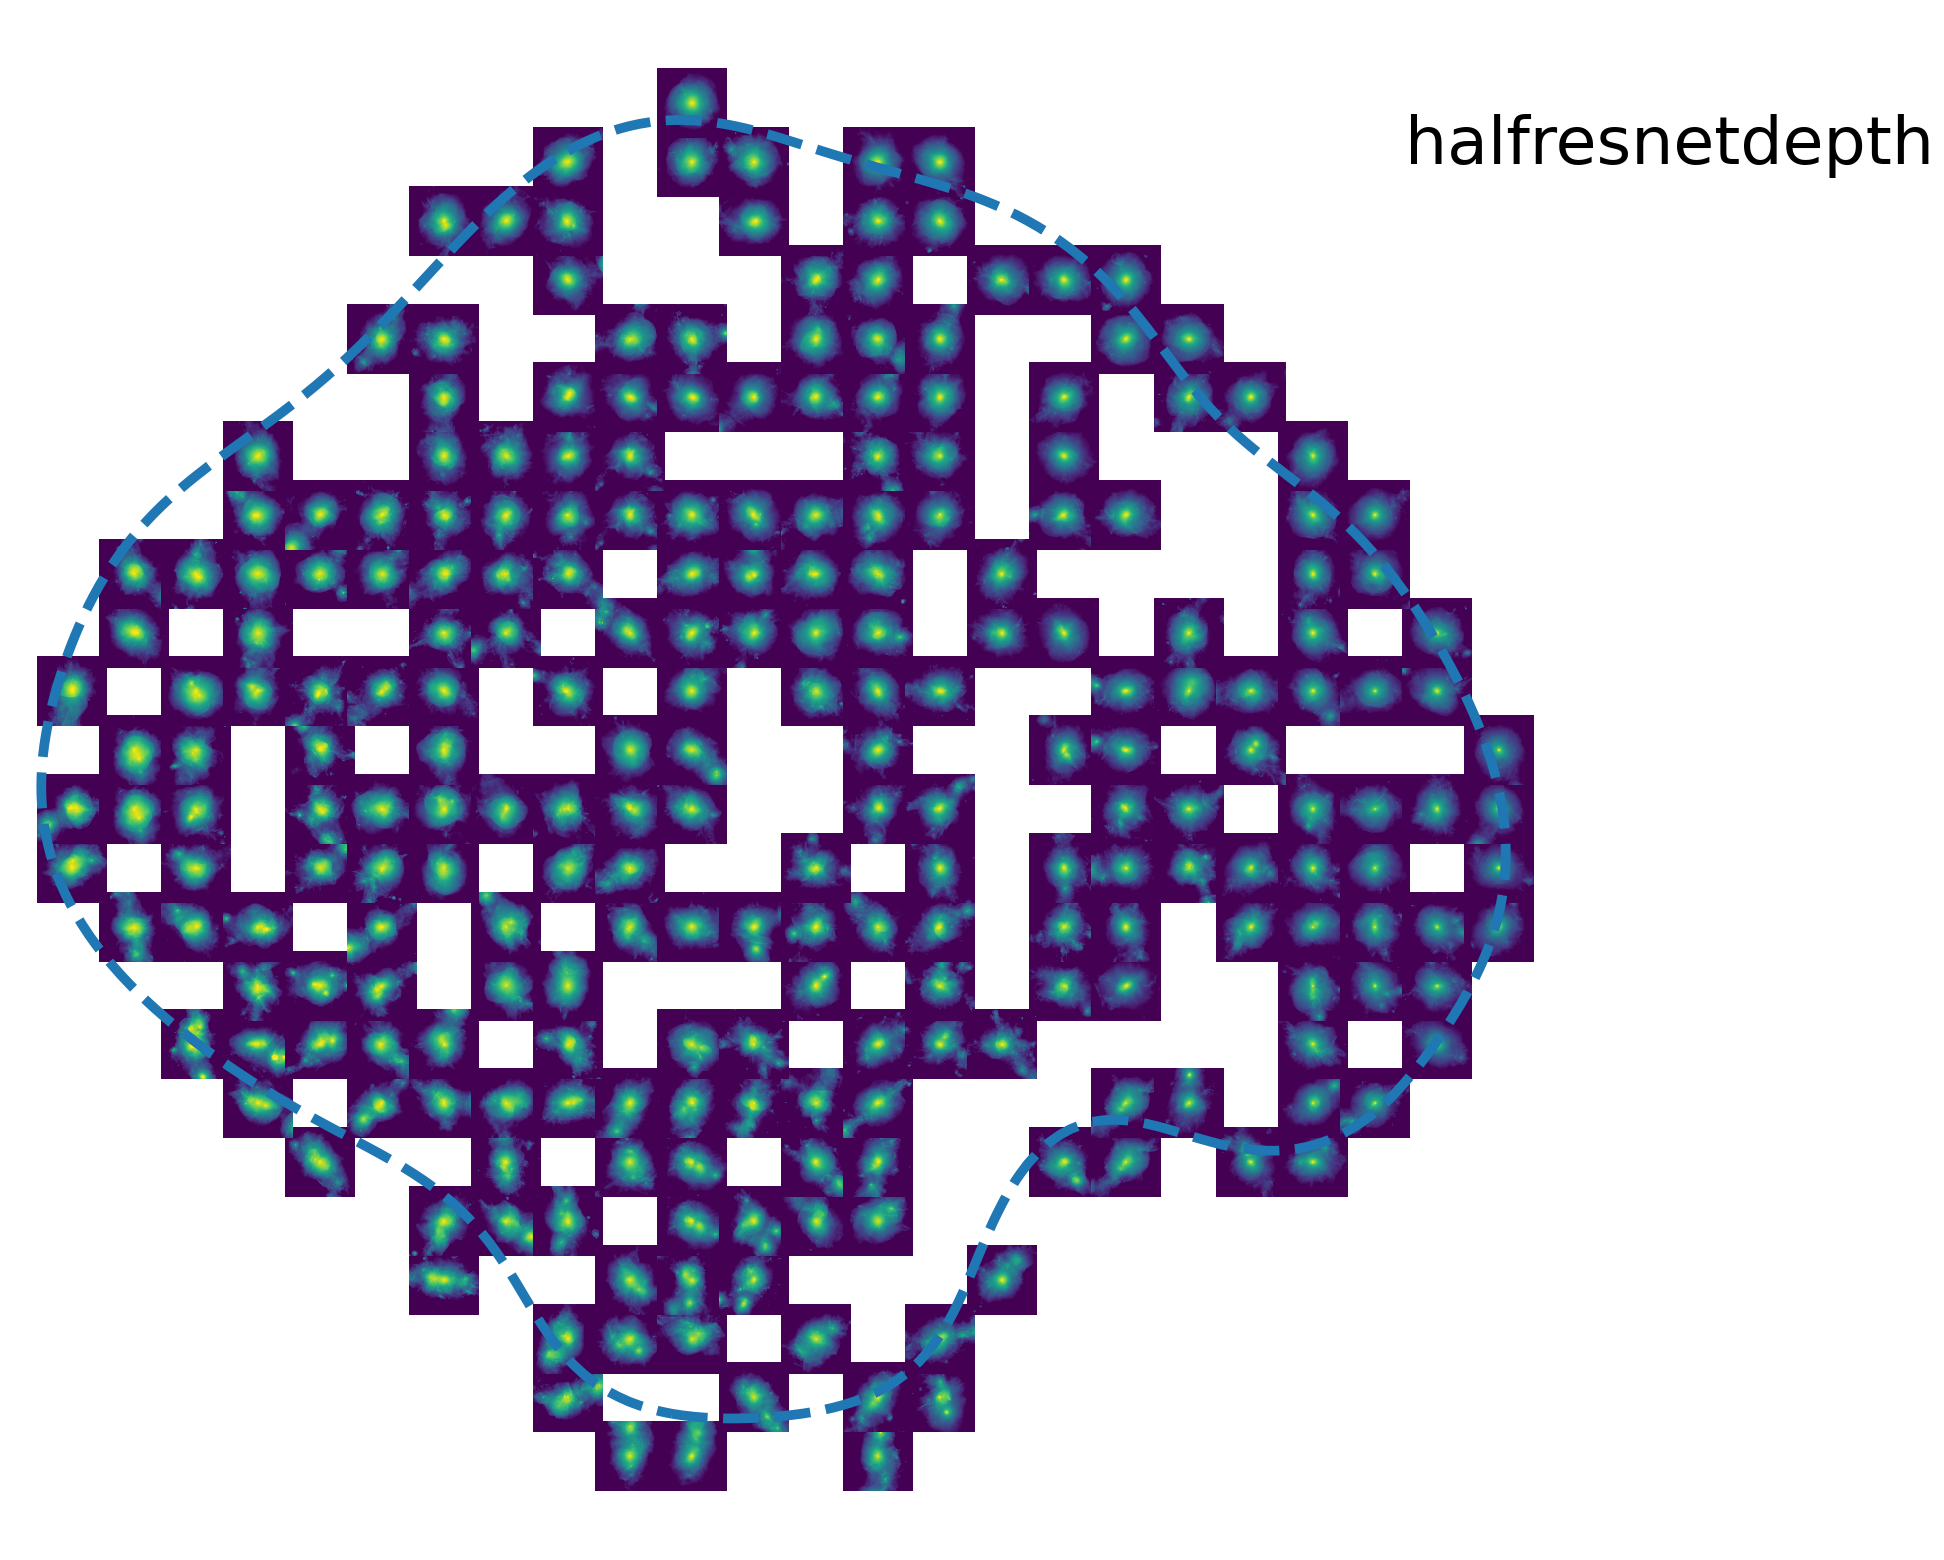

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(772, 12) (772, 2)


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


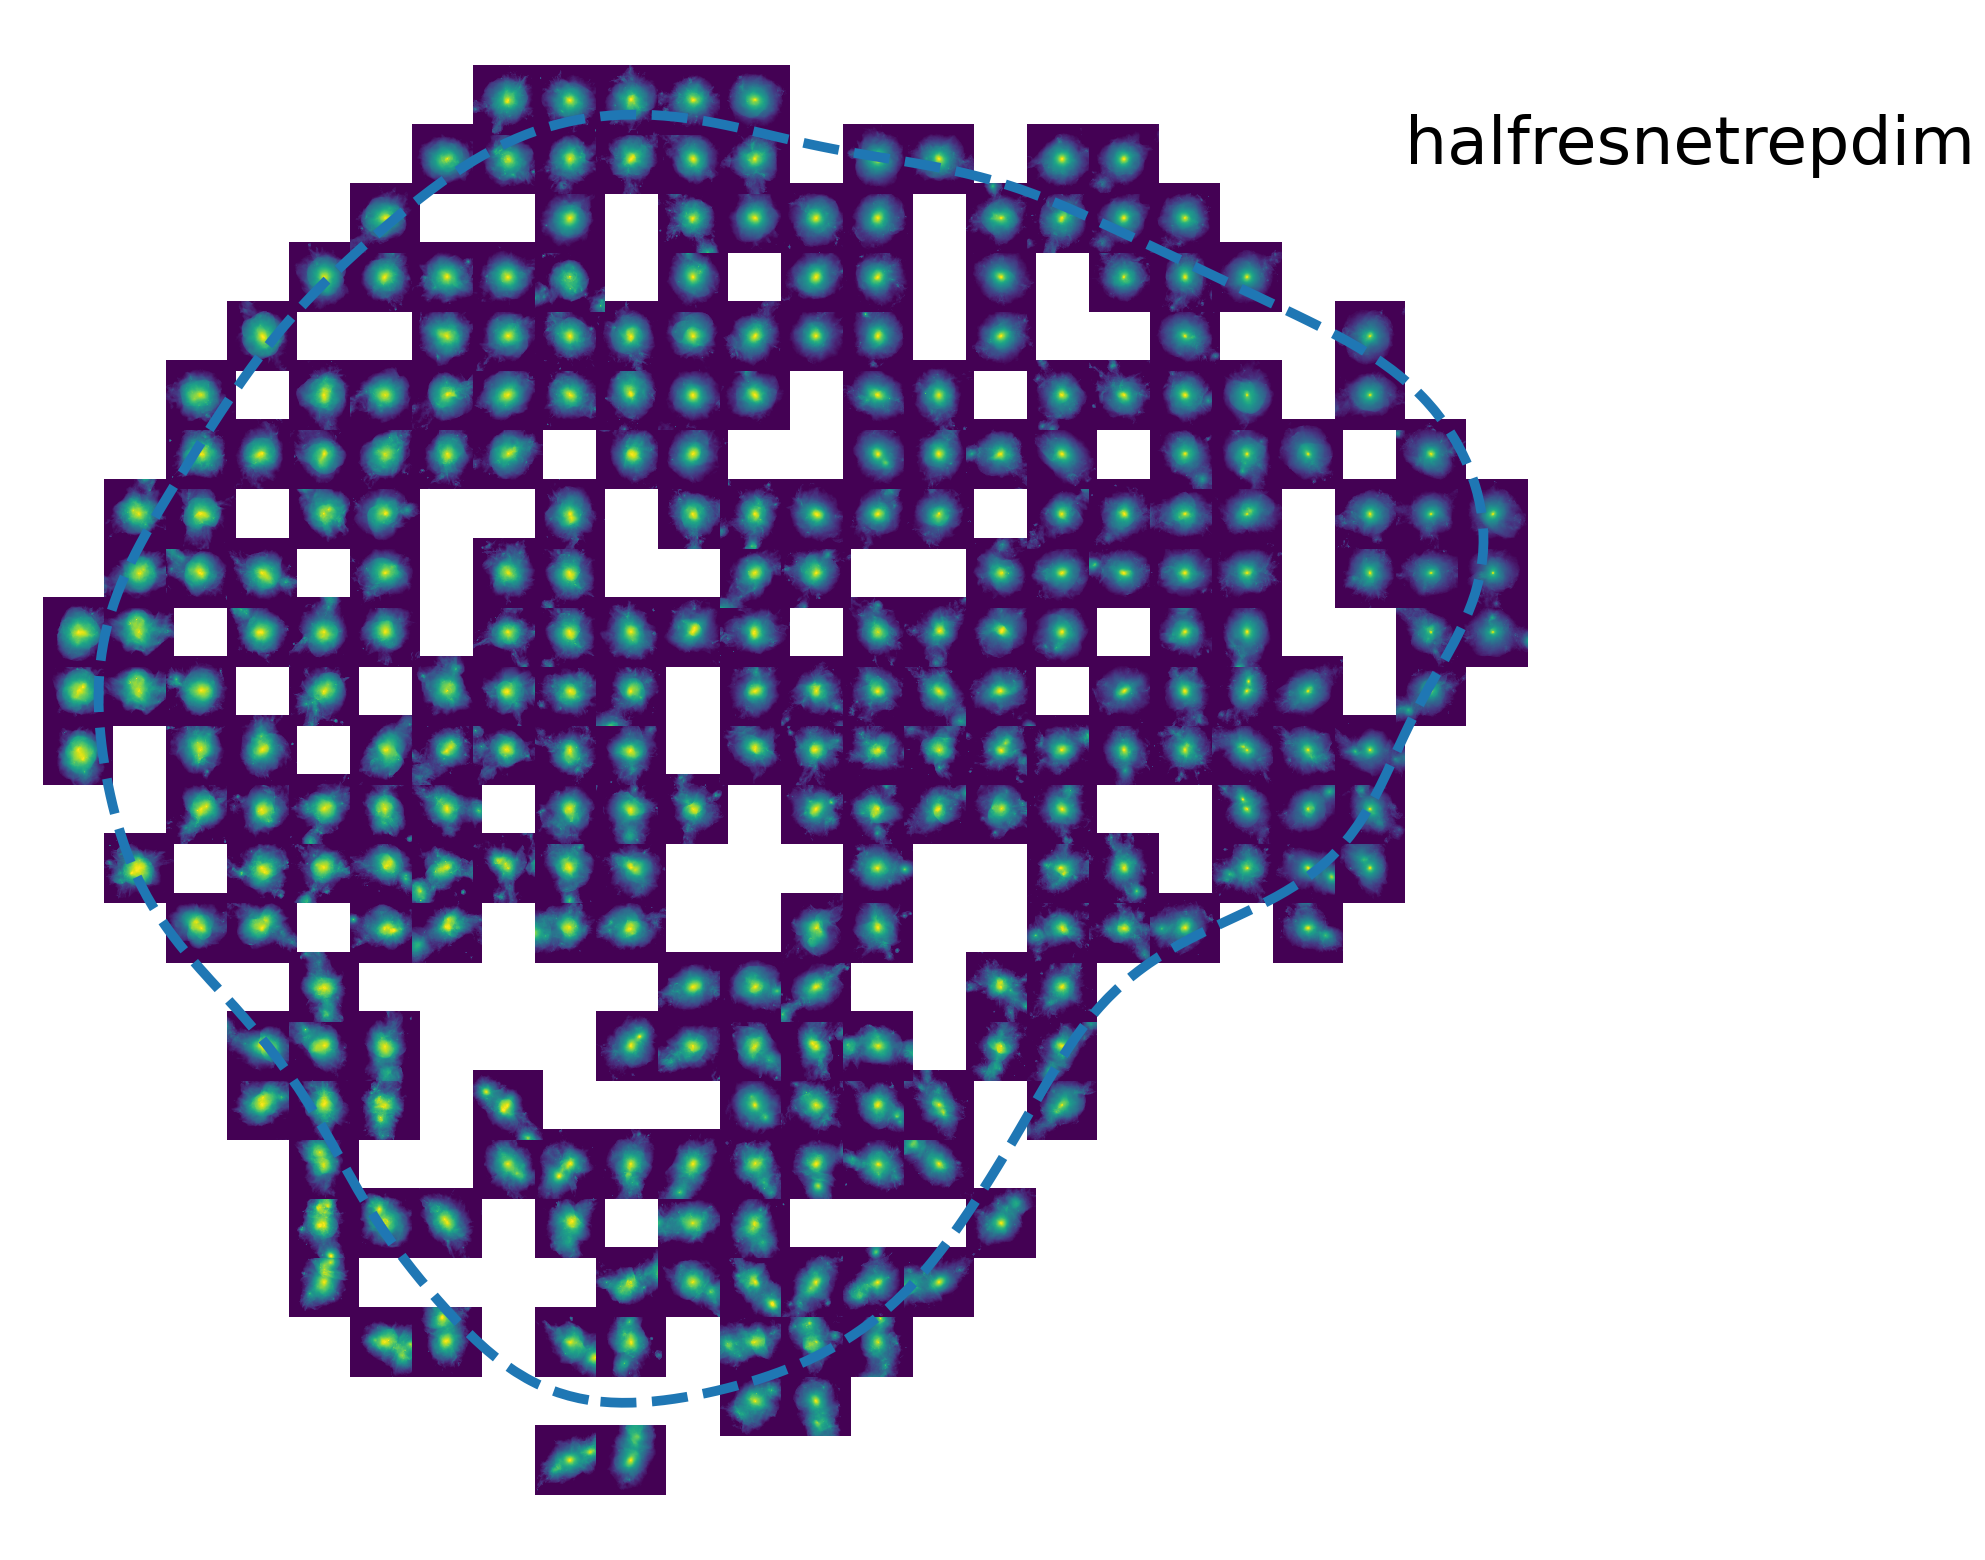

/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(772, 12) (772, 2)


/vera/u/uchadaya/miniforge3/envs/cluster_generator/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


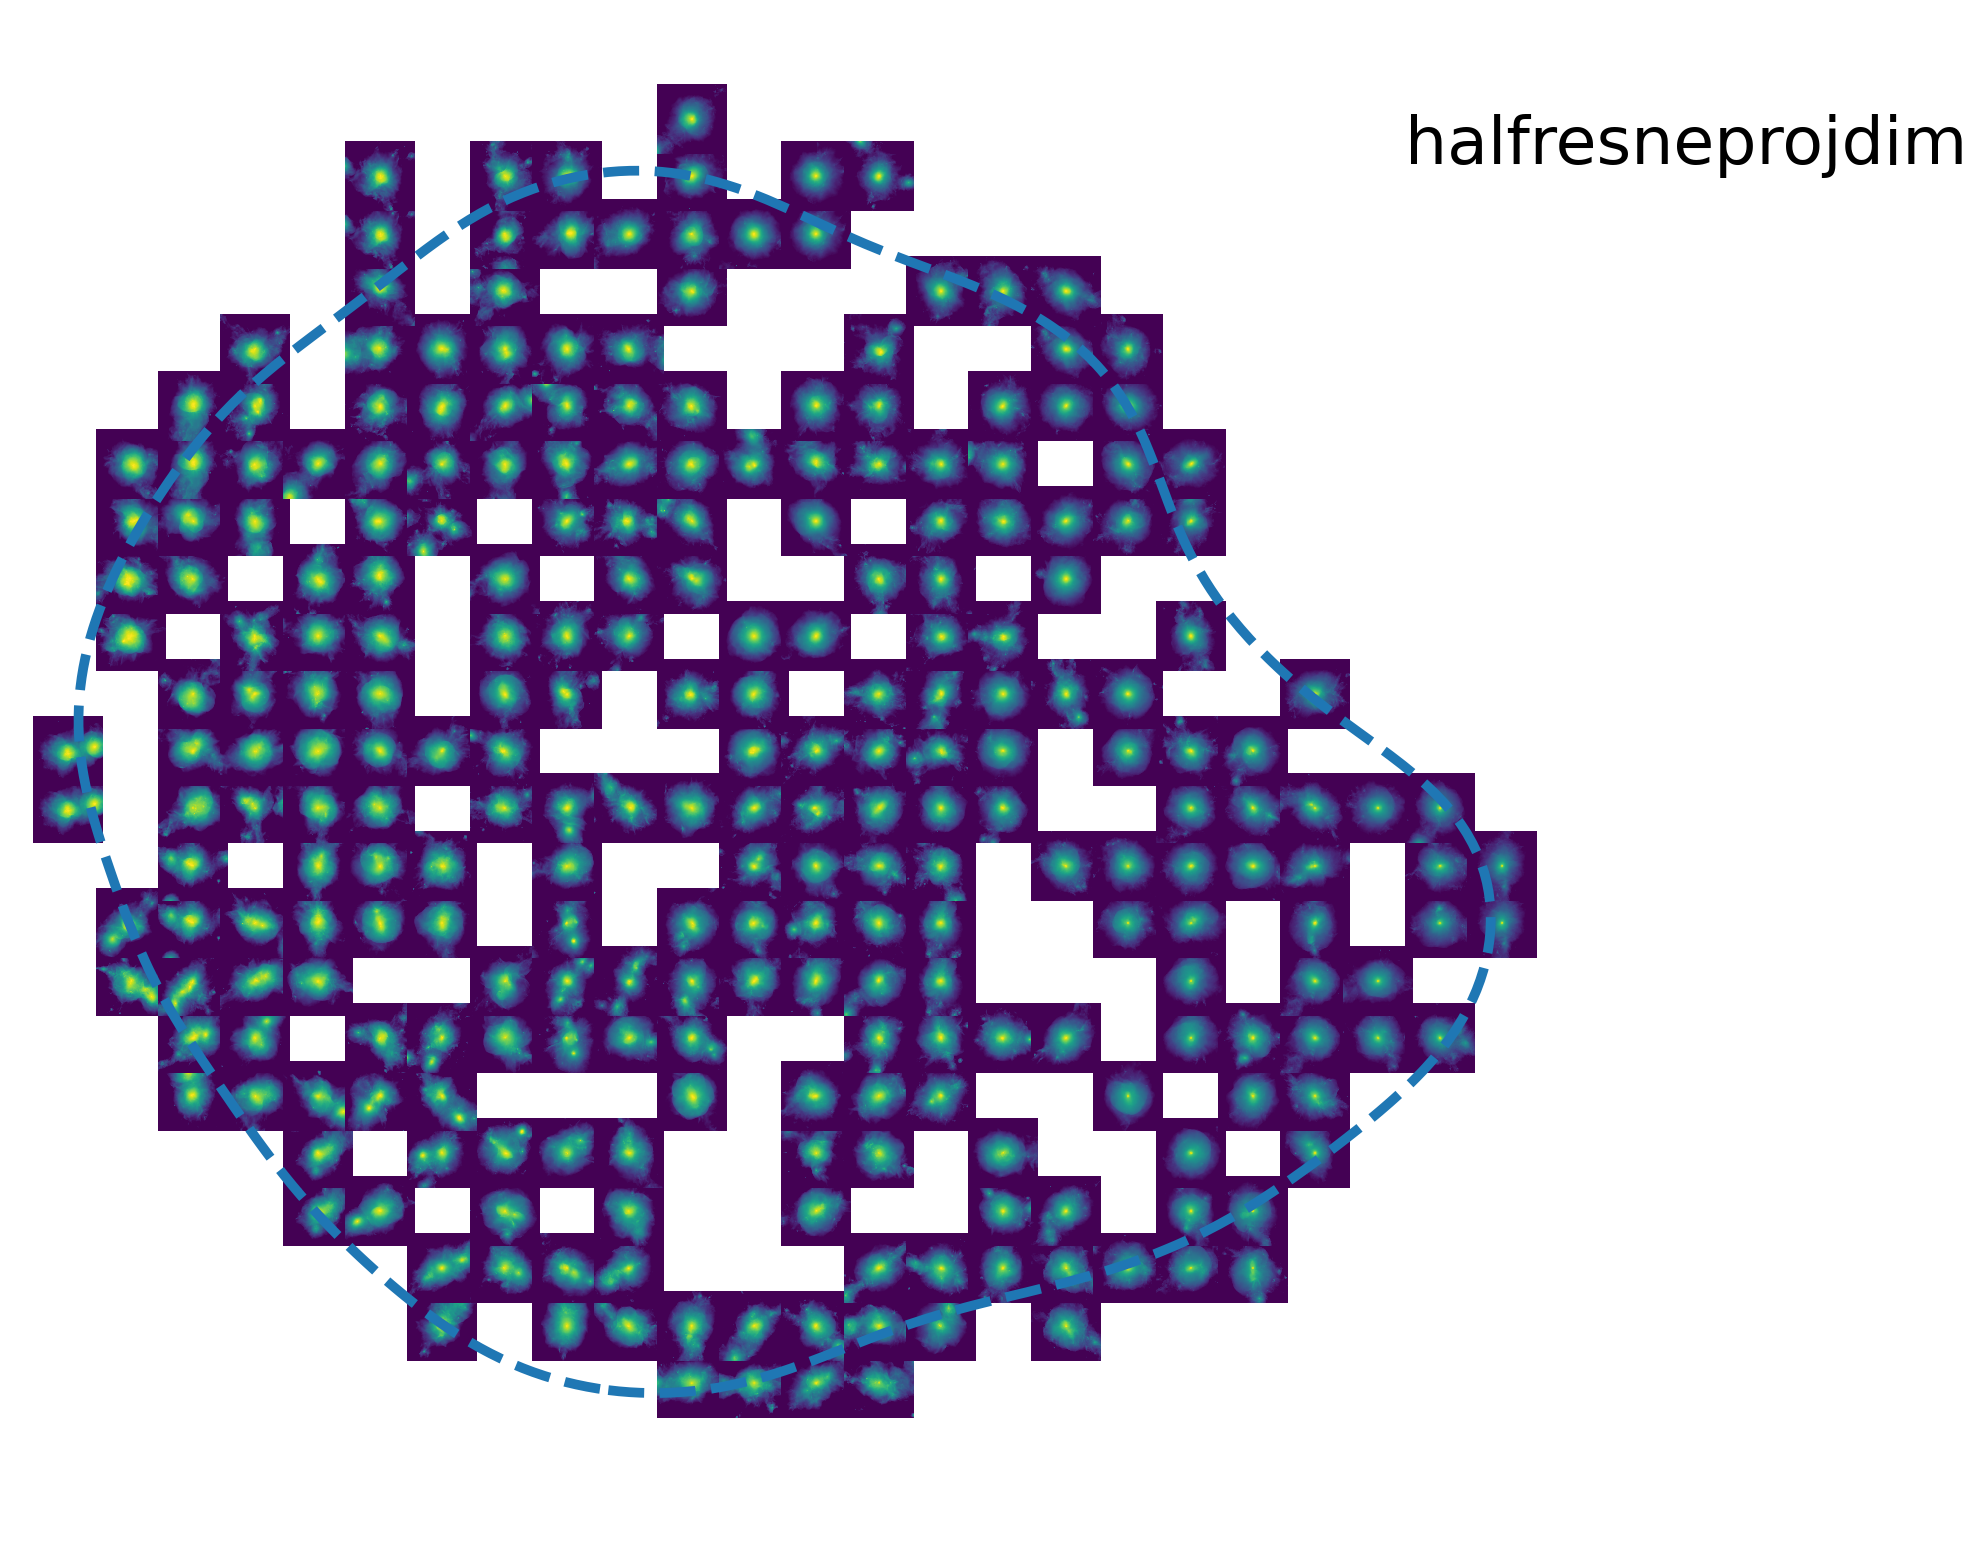

In [12]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import numpy as np
from astropy.io import fits
from matplotlib import cm

def load_image(filename):
    
    def get_central_crop(img, num_pixel=20):
        size = img.shape[0]
        center_coordinate = size//2
        upper = center_coordinate + num_pixel//2
        lower = center_coordinate - num_pixel//2
    
        return img[lower:upper, lower:upper]
    
    def stretch(x):
        x[x<=0] = np.nan
        x = np.log10(x)
        x[x<-7] = np.nan
        
        a_min = np.nanmedian(x)
        a_max = np.nanquantile(get_central_crop(x), 0.99)
        
        x = np.nan_to_num(x, nan=a_min, posinf=a_min, neginf=a_min)
        x = np.clip(x, a_min, a_max)
        
        x -= a_min
        x /= (a_max - a_min)
        
        return np.array(x*(2**8 - 1), dtype=np.uint8)
    
    with fits.open(filename) as hdul:
            
        X = hdul['0.5-5.0'].data
        
    X = stretch(X)

    return (X[...,np.newaxis])

def plot_sorted_images(basePath, NUM_IMAGES_PER_SIDE = 24):
    try:
        name = basePath.split('test-')[1].split('/')[0]
    except IndexError:
        name = 'fiducial'
    
    filenames = get_filenames(basePath, NUM_IMAGES_PER_SIDE=NUM_IMAGES_PER_SIDE)
    u = get_umap(basePath)
    u0, u1, u0v, u1v  = get_u_mesh(u, NUM_IMAGES_PER_SIDE=NUM_IMAGES_PER_SIDE)
    
    fig, ax = plt.subplots(figsize=(20., 20.))

    PADDING = 0.5
    ax.set_xlim(u0[0]-PADDING, u0[-1]+PADDING)
    ax.set_ylim(u1[0]-PADDING, u1[-1]+PADDING)
    
    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
            u0d = u0v[i,j]
            u1d = u1v[i,j]
            filename = filenames[i,j].replace('../../../','../../')

            if filename != "":
                im = load_image(filename)
                TARGET_IMAGE_SIZE = 50
                zoom_factor = TARGET_IMAGE_SIZE/im.shape[0]

                imagebox = OffsetImage(im, zoom=zoom_factor)
                ab = AnnotationBbox(imagebox, (u0d, u1d), frameon=False)
                ab.set_zorder(0)
                ax.add_artist(ab)
                ax.axis('off')
                
    sns.kdeplot(x=u[:,0], y=u[:,1], levels=[0.2], linewidths=7, color=cmap(basePath.index(basePath)), linestyles='dashed')
    plt.text(0.9, 0.9, name, color='k', size=48, transform=ax.transAxes)
    plt.savefig('../../temp/images_' + name + '.pdf')
    plt.show()

for basePath in basePaths:
    plot_sorted_images(basePath)
